In [1]:
import os
os.environ['ZFIT_DISABLE_TF_WARNINGS'] = '1'
# numpy is used for generating, storing, and plotting data
import numpy as np
import pandas
import uproot

# in order to visualise the results of the computation, we use matplotlib
import matplotlib as mpl

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.LHCb2)
plt.rcParams['text.usetex'] = True
#plt.rcParams['figure.dpi'] = 50
# for histograms boost has an easy api and is very fast
import hist
# for statistical distributions we can use a lot from scipy
from scipy import stats

## File import, data processing
 

In [2]:

#MC used for training
path = '/eos/lhcb/user/p/pgaigne/MC/26266050/MC-2016-26266050.root'
with uproot.open(path) as file:
    
    xicc_MC = file['tuple_sel_Xicc/DecayTree']
    
    xicc_MC_rec = file['tuple_sel_rec/DecayTree']

    branches_we_want = ["Xicc_M","Xicc_M_DTF_Lc","Lc_M","Xicc_TRUEID","Lc_TRUEID","LcP_TRUEID","LcPi_TRUEID","LcK_TRUEID","LcP_MC_MOTHER_ID","LcP_MC_GD_MOTHER_ID","LcK_MC_MOTHER_ID","LcK_MC_GD_MOTHER_ID","LcPi_MC_MOTHER_ID","LcPi_MC_GD_MOTHER_ID","XiccPi1_TRUEID","XiccPi1_MC_MOTHER_ID","XiccPi2_TRUEID","XiccPi2_MC_MOTHER_ID","XiccK_TRUEID","XiccK_MC_MOTHER_ID"]

    xicc_MC_data = xicc_MC.arrays(expressions = branches_we_want, library='pd')
    xicc_MC_rec_data = xicc_MC_rec.arrays(expressions = branches_we_want, library='pd')
    
#Data used for training
path = "/eos/lhcb/user/p/pgaigne/STEP2/2016/Collision-2016-Xiccpp-job74-75-reduced.root"
with uproot.open(path) as file:
    xicc_bkg_rec = file['DecayTree']
    branches_we_want = ["Xicc_M","Xicc_M_DTF_Lc","Lc_M"] 
    xicc_bkg_rec_data = xicc_bkg_rec.arrays(expressions = branches_we_want, library='pd')
    #data_sideband = xicc_rec['Xicc_M'].arrays(library='pd')

path = "/eos/lhcb/user/p/pgaigne/STEP1/Collision-2016-MD-Xicc-job30.root"
with uproot.open(path) as file:
    xicc_bkg_rec = file['DecayTree']
    branches_we_want = ["Xicc_M","Xicc_M_DTF_Lc","Lc_M"] 
    xicc_bkg_data1 = xicc_bkg_rec.arrays(expressions = branches_we_want, library='pd')

path = "/eos/lhcb/user/p/pgaigne/STEP1/Collision-2016-MD-Xicc-job30.root"
with uproot.open(path) as file:
    xicc_bkg_rec = file['DecayTree']
    branches_we_want = ["Xicc_M","Xicc_M_DTF_Lc","Lc_M"] 
    xicc_bkg_data2 = xicc_bkg_rec.arrays(expressions = branches_we_want, library='pd')  

    
xicc_bkg_data = pandas.concat([xicc_bkg_data1, xicc_bkg_data2])

## Cut selection

In [3]:
cut = "(abs(Xicc_TRUEID)==4422&abs(Lc_TRUEID)==4122&abs(LcP_TRUEID)==2212&abs(LcPi_TRUEID)==211&abs(LcK_TRUEID)==321&(abs(LcP_MC_MOTHER_ID)==4122|abs(LcP_MC_GD_MOTHER_ID)==4122)&(abs(LcK_MC_MOTHER_ID)==4122|abs(LcK_MC_GD_MOTHER_ID)==4122)&(abs(LcPi_MC_MOTHER_ID)==4122|abs(LcPi_MC_GD_MOTHER_ID)==4122)&abs(XiccPi1_TRUEID)==211&abs(XiccPi1_MC_MOTHER_ID)==4422&abs(XiccPi2_TRUEID)==211&abs(XiccPi2_MC_MOTHER_ID)==4422&abs(XiccK_TRUEID)==321&abs(XiccK_MC_MOTHER_ID)==4422)"
xicc_MC_data = xicc_MC_data.query(cut+"&(Lc_M>2270)&(Lc_M<2306)")
xicc_MC_rec_data = xicc_MC_rec_data.query(cut+"&(Lc_M>2270)&(Lc_M<2306)")

xicc_bkg_rec_data = xicc_bkg_rec_data.query("(Lc_M>2270)&(Lc_M<2306)")
xicc_bkg_data = xicc_bkg_data.query("(Lc_M>2270)&(Lc_M<2306)")

data_sig_M = xicc_MC_data.Xicc_M
data_sig_rec_M = xicc_MC_rec_data.Xicc_M
data_sideband_rec_M = xicc_bkg_rec_data.Xicc_M
data_sideband_M = xicc_bkg_data.Xicc_M


data_sig_cut = xicc_MC_data.query("abs(Xicc_M-3621)<15")
data_sig_rec_cut = xicc_MC_rec_data.query("abs(Xicc_M-3621)<15")
data_sideband_rec_cut = xicc_bkg_rec_data.query("(Xicc_M>3800)&(Xicc_M<3900)")
data_sideband_cut = xicc_bkg_data.query("(Xicc_M>3800)&(Xicc_M<3900)")

data_sig_cut_M = data_sig_cut.Xicc_M
data_sig_rec_cut_M = data_sig_rec_cut.Xicc_M
data_sideband_rec_cut_M = data_sideband_rec_cut.Xicc_M
data_sideband_cut_M = data_sideband_cut.Xicc_M

## Signal selected

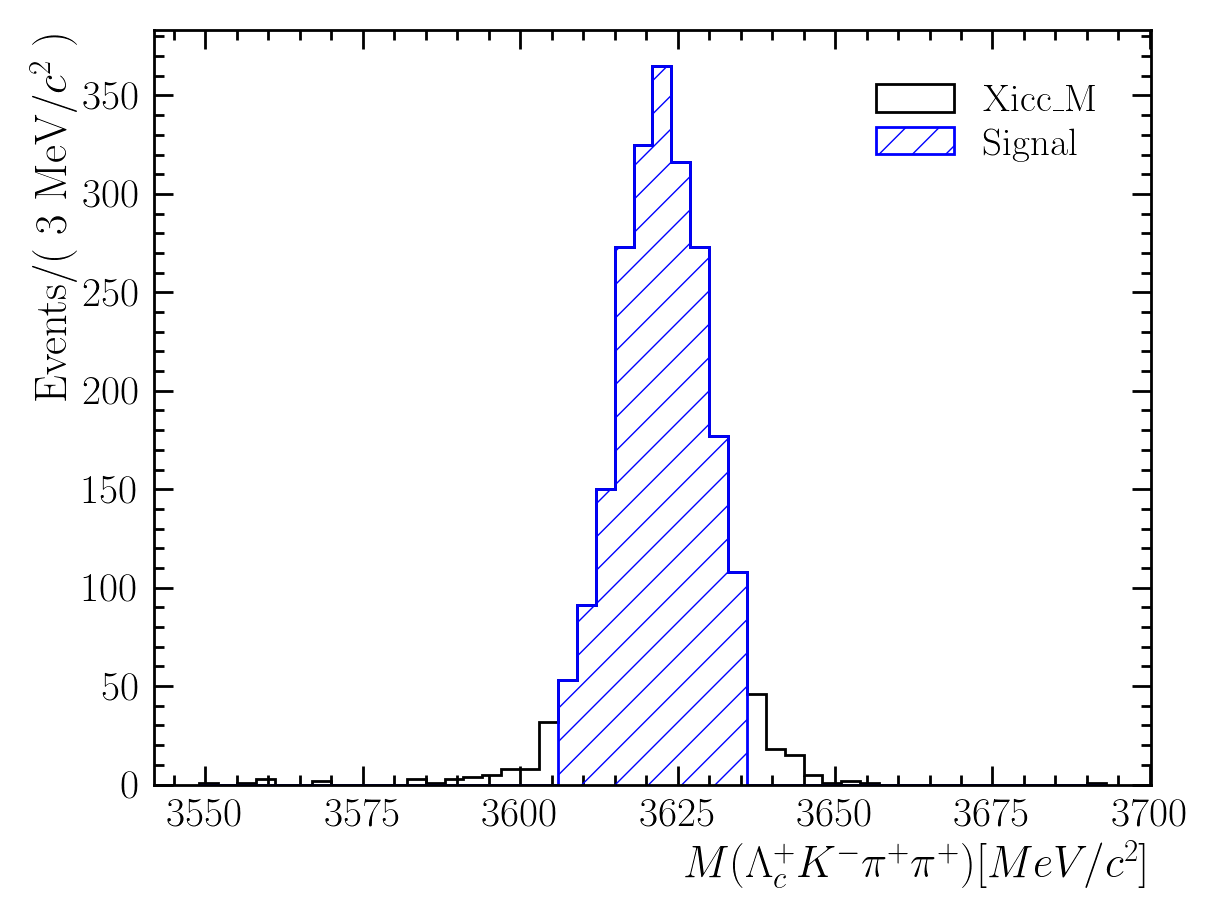

In [4]:
n, bins, patches = plt.hist([data_sig_cut_M, data_sig_M], 
                            bins=48, 
                            density = False, 
                            range=[3621-72, 3621+72],
                            histtype='step', 
                            label=["Signal", "Xicc_M"], 
                            color=['b','black']
                            )

hatches = ['/', '']
for patch_set, hatch in zip(patches, hatches):
    for patch in patch_set:
        patch.set_hatch(hatch)

        
plt.xlabel("$M(\Lambda_c^+ K^- \pi^+ \pi^+)[MeV/c^2]$")
plt.ylabel(f'Events/( 3 MeV/$c^2$ )');
plt.legend()

In [5]:
print(f"Number of signal events : {len(data_sig_cut_M)}")

Number of signal events : 2131


## Sideband selected

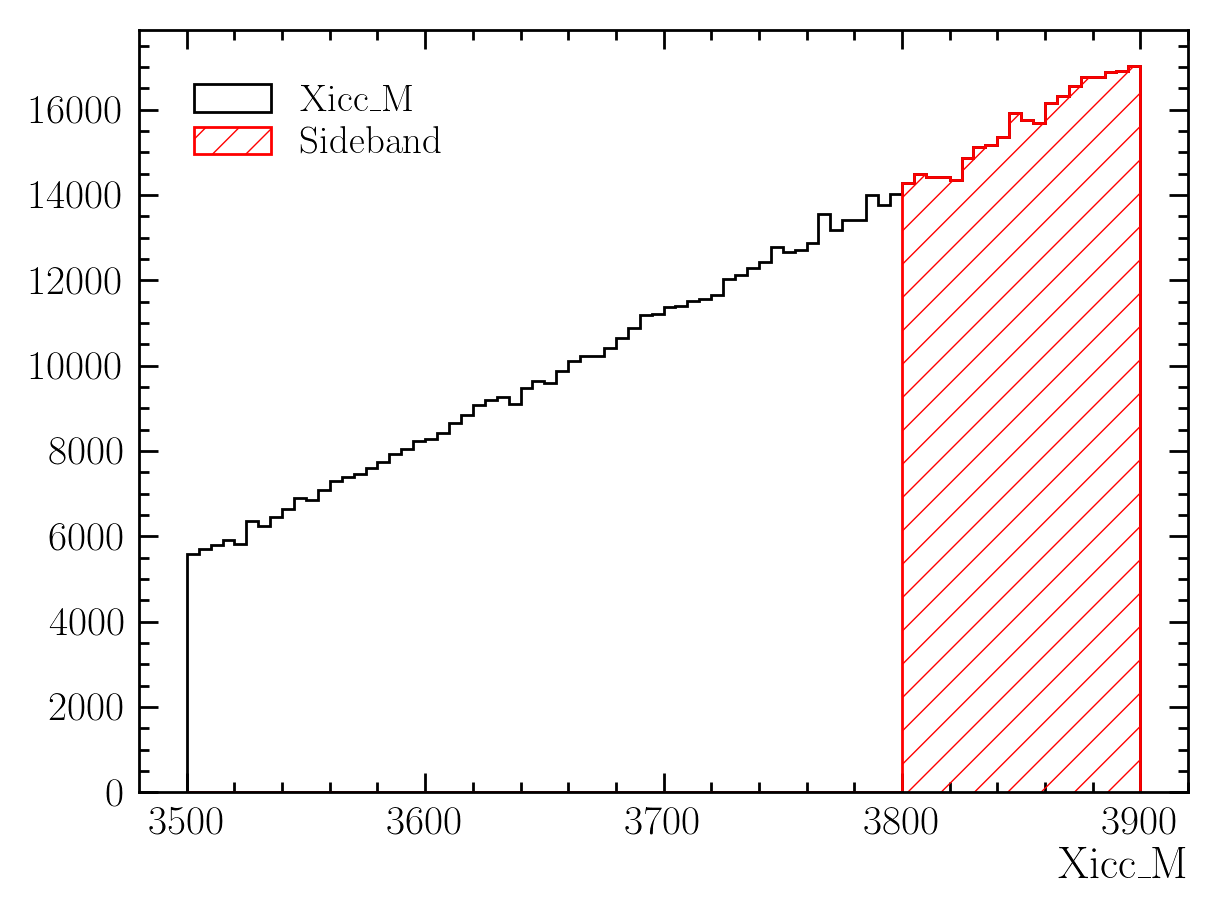

In [6]:
n, bins, patches = plt.hist([data_sideband_cut_M, data_sideband_M], 
                            bins=80, 
                            density = False, 
                            range=[3500, 3900],
                            histtype='step', 
                            label=["Sideband", "Xicc_M"], 
                            color=['r','black']
                            )

hatches = ['/', '']
for patch_set, hatch in zip(patches, hatches):
    for patch in patch_set:
        patch.set_hatch(hatch)

        
plt.xlabel("Xicc_M")

plt.legend(loc='upper left')

In [7]:
print(f"Number of sideband events : {len(data_sideband_cut_M)}")

Number of sideband events : 313232


## Signal selected

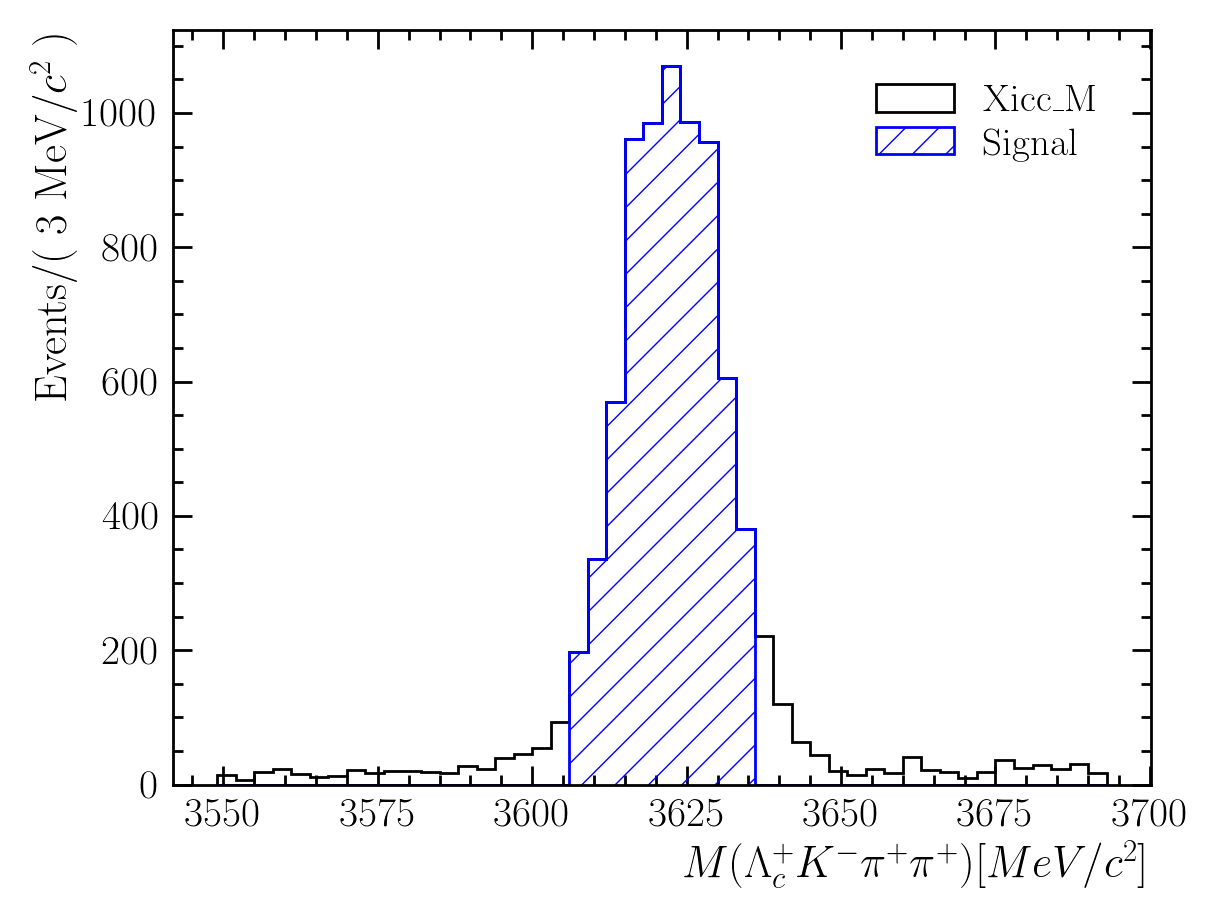

In [8]:
n, bins, patches = plt.hist([data_sig_rec_cut_M, data_sig_rec_M], 
                            bins=48, 
                            density = False, 
                            range=[3621-72, 3621+72],
                            histtype='step', 
                            label=["Signal", "Xicc_M"], 
                            color=['b','black']
                            )

hatches = ['/', '']
for patch_set, hatch in zip(patches, hatches):
    for patch in patch_set:
        patch.set_hatch(hatch)

        
plt.xlabel("$M(\Lambda_c^+ K^- \pi^+ \pi^+)[MeV/c^2]$")
plt.ylabel(f'Events/( 3 MeV/$c^2$ )');
plt.legend()

In [9]:
print(f"Number of signal events : {len(data_sig_cut_M)}")

Number of signal events : 2131


## Sideband selected

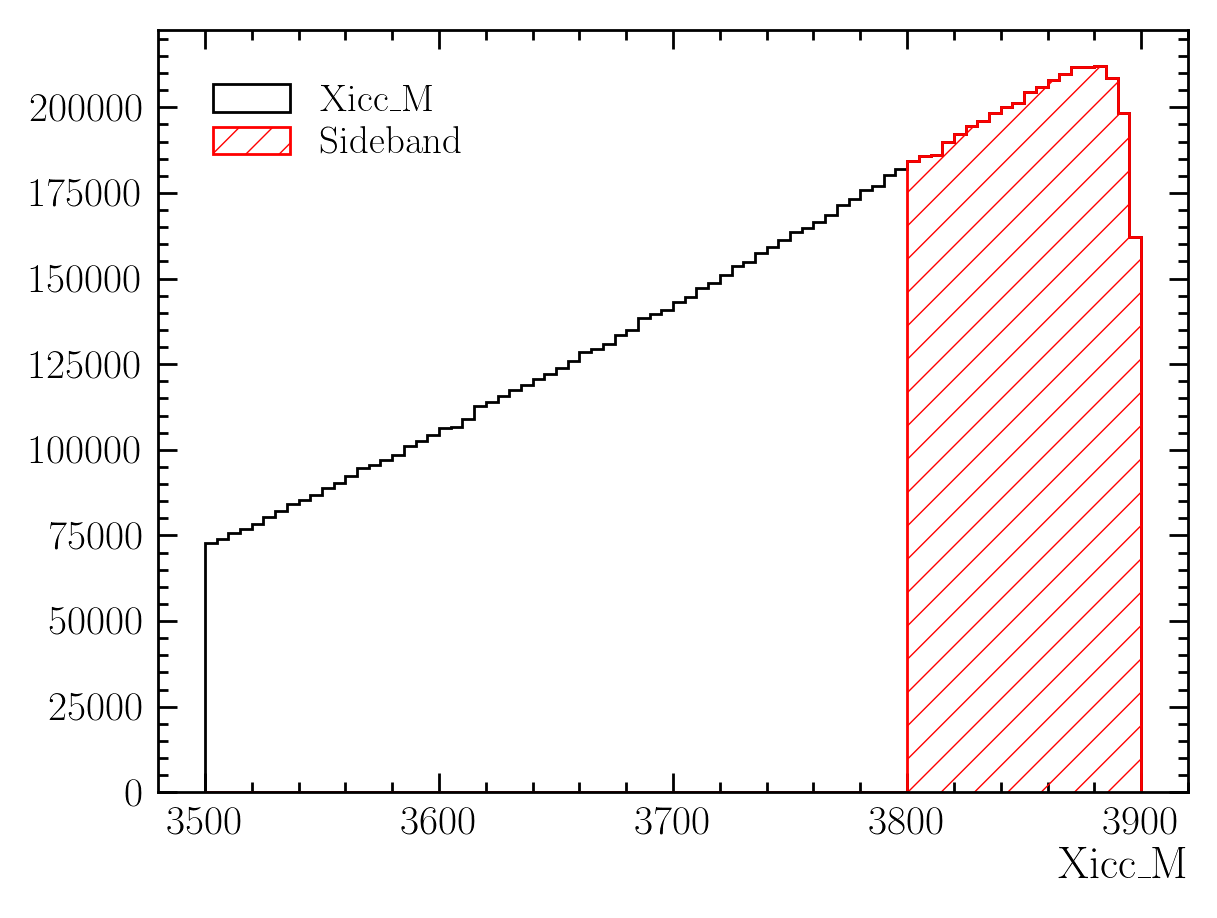

In [10]:
n, bins, patches = plt.hist([data_sideband_rec_cut_M, data_sideband_rec_M], 
                            bins=80, 
                            density = False, 
                            range=[3500, 3900],
                            histtype='step', 
                            label=["Sideband", "Xicc_M"], 
                            color=['r','black']
                            )

hatches = ['/', '']
for patch_set, hatch in zip(patches, hatches):
    for patch in patch_set:
        patch.set_hatch(hatch)

        
plt.xlabel("Xicc_M")

plt.legend(loc='upper left')

In [11]:
print(f"Number of sideband events : {len(data_sideband_cut_M)}")

Number of sideband events : 313232
